# Act 1

Act 1 outline:
- flash between SEI and average image
- fade from B&W to colored tiff w/ detection dot
- animate posterchild path on tiff
- switch from tiff to larger jpgs and zoom out

#### most of Act 1 does not utilize the Orbit + Dot classes, and it uses the old y4 data.

In [2]:
# import useful classes
from importlib import reload
import orbitdot
from orbitdot import Orbit, Dot, getPlanetPos
import timeline
from timeline import Timeline
import observer
from observer import Observer
#reload()
# matplotlib and video
import matplotlib.pyplot as pl
from matplotlib import animation
from IPython.display import Video
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
# astropy
import astropy
from astropy import wcs
import astropy.table as tb
from astropy.io import fits
from astropy.wcs import WCS
import astropy.io.fits as pf
from astropy.time import Time
from reproject import reproject_interp
from astropy.visualization import ZScaleInterval
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import solar_system_ephemeris, EarthLocation, get_body_barycentric, SkyCoord
# others
import scipy
import cx_Oracle
import numpy as np
import pandas as pd
import getDesFiles as gdf
from scipy import ndimage
import transformation as tr
from jupyterthemes import jtplot
from scipy.spatial import distance
jtplot.style(ticks=True, grid=False)

In [331]:
## load the images used in movie

# average of posterchild TNO (old ID 213, new ID 375) detection #3
average = fits.open(get_pkg_data_filename('dataa/213average.fz'))
# SEI of posterchild TNO, detection #3
detection = fits.open(get_pkg_data_filename('dataa/213SEI.fz'))
# first color image to appear in movie
tiff = pl.imread('dataa/213dark.jpg')

smallmel = pl.imread('dataa/biggri.jpg');
smallmel = smallmel[::-1,:,:]
with open('dataa/biggri.wcs') as f:
    smallmelwcs = WCS(f.read())
    
bigmel = pl.imread('dataa/mel2.jpg');
bigmel = bigmel[::-1,:,:]
with open('dataa/mel2.wcs') as f:
    bigmelwcs = WCS(f.read())

biggermel = pl.imread('dataa/mel3.jpg') #mel3
with open('dataa/mel3.wcs') as f:
    biggermelwcs = WCS(f.read())
# (in retrospect, could have used the biggestmel image for entire orbit-drawing part,
# but these pictures were pasted together on-demand whenever I hit a boundary on the
# current smaller image.)

In [3]:
# open relevant FITS files
alltnoi = tb.Table.read('dataa/y4_tno_table.fits')
big_tno = tb.Table.read('dataa/orbits_culled_ast.fits', 2)

#include calculated RA and DEC columns
big_tno['RA'] = big_tno['DETECT'][:,0]*180/np.pi
big_tno['DEC'] = big_tno['DETECT'][:,1]*180/np.pi
alltnod = big_tno[(big_tno['OBJECTID'] > 0)]

#sort them into 2 main lists,
# - tnoinfo: list with the orbital elements of each TNO
# - tnodetect: list with the times and positions of each detection of each TNO
tnoinfo = []
for i in range(0,316):
    if -1 < i and i < 10:
        tnoinfo.append(alltnoi[(alltnoi['DES']=="DES000%s" % (i))])
    if i == 10:
        tnoinfo.append(alltnoi[(alltnoi['DES']=="DES0010")])
    if 10 < i and i < 100:
        tnoinfo.append(alltnoi[(alltnoi['DES']=="DES00%s" % (i))])
    if i == 100:
        tnoinfo.append(alltnoi[(alltnoi['DES']=="DES0100")])
    if 100< i and i < 1000:
        tnoinfo.append(alltnoi[(alltnoi['DES']=="DES0%s" % (i))])

tnodetect = []
for i in range(0,316):
    tnodetect.append(alltnod[(alltnod['ORBITID']== i)])

In [181]:
poster_ID = 213
poster_info = tnoinfo[poster_ID]
poster_detect = tnodetect[poster_ID]
poster_ra = poster_detect['RA'][2]
poster_dec = poster_detect['DEC'][2]

# time of poster detection
t1 = astropy.time.Time((2000+poster_detect[2]['TDB']), format='decimalyear', scale='tdb')

In [170]:
def reproject_crop_one(projected, match_to, tno_ra, tno_dec, difference, vmin, vmax, slidetext):
    '''for the purpose flashing between the SEI and coadd,
       function uses reproject_interp to match wcs of two images
       > 'projected' is the image we are seeing ( can be coadd or SEI )
       > 'match_to' is the image whose wcs we are matching to ( SEI in our case )
       - tno_ra, tno_dec: coords for the center pixel
       - difference: the VERTICAL difference between edge of frame and center pixel ( movie ratio )
       - vmin, vmax: manually select values for colorscale
       - slidetext: for the movie, EX "detection" and "average"
    '''

    #first, reproject coadd onto detection
    in_1 = projected[1]
    in_2 = match_to[1].header
    array, footprint = reproject_interp(in_1, in_2)
    
    #crop according to inputs
    w = astropy.wcs.WCS(in_2)
    xdiff = int(difference*1.777)
    center_y, center_x = w.all_world2pix(tno_ra, tno_dec, 0)
    crop_x= int(center_x) - xdiff
    crop_y= int(center_y) - difference
    new_head = in_2.copy()
    new_head['CRPIX1'] = new_head['CRPIX1'] - crop_y
    new_head['CRPIX2'] = new_head['CRPIX2'] - crop_x
    
    #rotate for correct axes directions
    r_image = ndimage.rotate(array[crop_x:(int(center_x)+xdiff),crop_y:(int(center_y)+difference)], 90) 
    
    #plot
    ax1 = pl.subplot(projection=WCS(new_head), slices=('y','x'))
    pl.subplots_adjust(left=0, right=1, bottom=0, top=1)
    pl.text(730, 55, poster_info['MPC'][0],fontsize=36,color="white")
    pl.text(125, 400, slidetext, fontsize=36, color="white")
    ax1.imshow(r_image[::-1], vmin=vmin, vmax=vmax, cmap='gray',interpolation='bicubic')
    lon1, lat1 = ax1.coords
    lon1.set_format_unit('deg', decimal=True)
    lon1.grid(color='white', alpha=0.2)
    lat1.set_format_unit('deg', decimal=True)
    lat1.grid(color='white', alpha=0.2)
    ax1.set_ylim(ax1.get_ylim()[::-1])
    ax1.set_xlim(ax1.get_xlim()[::-1])

### Act 1 Scene 1
##### flash between average and detection

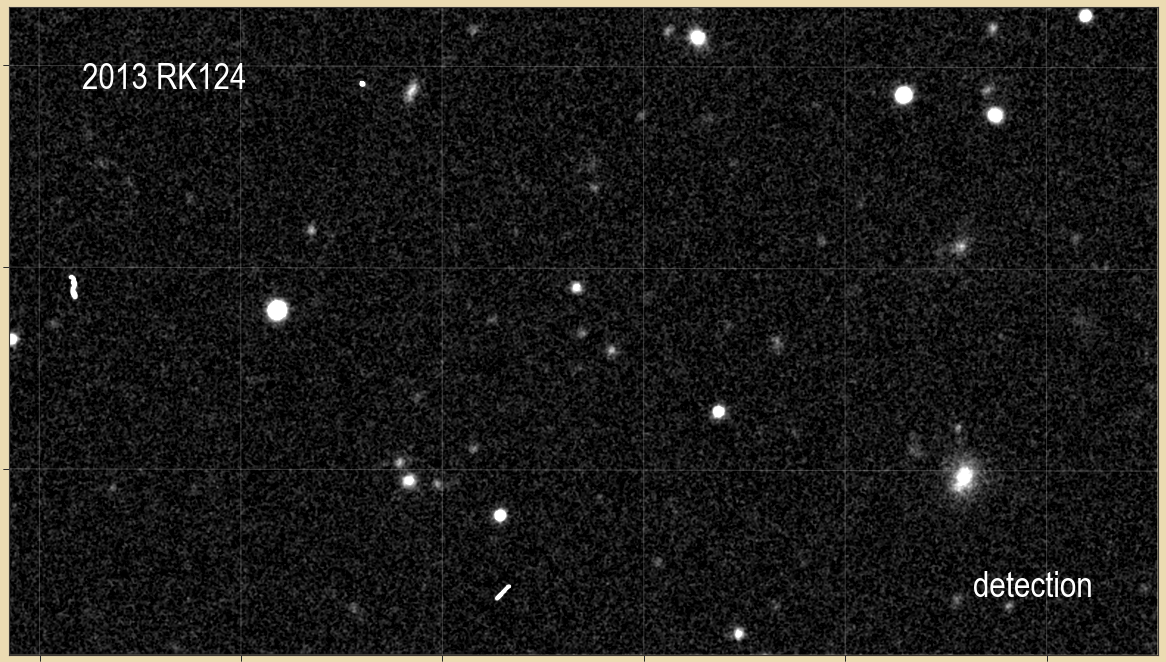

In [177]:
fig = pl.figure(figsize=(16,9))
def animate(i): 
    if (i % 2) == 0:             # even no. frames
        projected_input = detection
        slidetext = "detection"
        vmin,vmax = -20.4, 225.3
    else:                        # odd no. frames
        projected_input = average
        slidetext = "average"
        vmin,vmax = -3, 40  
    im = reproject_crop_one(projected_input, detection, poster_ra, 
                            poster_dec, 220, vmin, vmax, slidetext)
anim = FuncAnimation(fig, animate,frames=10,interval=1,blit=False)
anim.save('a1s1.mp4', writer='ffmpeg', fps=1, dpi=80)   
Video("a1s1.mp4")

### Act 1 Scene 2
##### color tiff image with detection point fading in

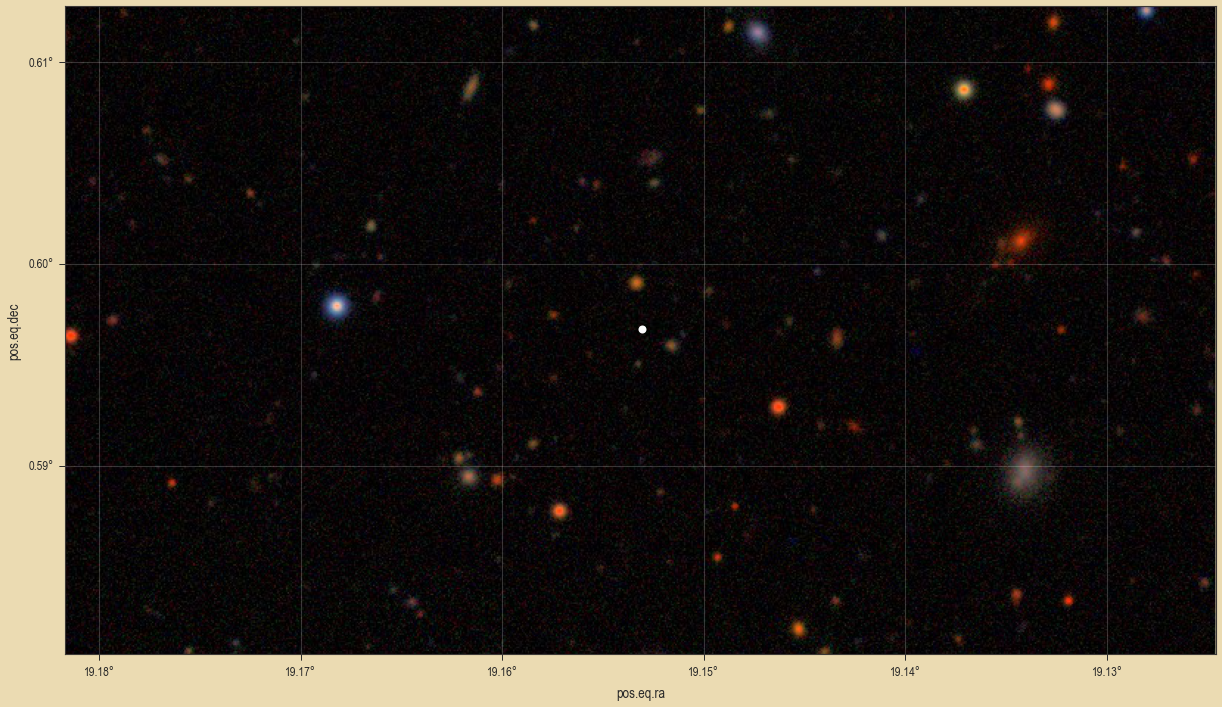

In [187]:
fig = pl.figure(figsize=(16,9))
difference, xdiff = 220, difference*1.777

in_2 = average[1].header
in_3 = detection[1].header
w = astropy.wcs.WCS(in_2)
center_x, center_y = w.all_world2pix(poster_ra, poster_dec, 0)
crop_x= int(center_x) - xdiff
crop_y= int(center_y) - difference

new_head = in_2.copy()
new_head['CRPIX1'] = new_head['CRPIX1'] - crop_x
new_head['CRPIX2'] = new_head['CRPIX2'] - crop_y

# plotting the tiff
pl.rcParams.update({'font.size': 15, 'font.family': 'arial narrow', 'text.usetex': False})
ax1 = pl.subplot(projection=WCS(new_head), slices=('x','y'))
pl.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax1.imshow(tiff[::-1][int(center_y - difference):int(center_y + difference),
                      int(center_x - (xdiff)):int(center_x + (xdiff))], 
           interpolation='hanning')
lon1, lat1 = ax1.coords
lon1.set_format_unit('deg', decimal=True)
lon1.grid(color='white', alpha=0.2)
lat1.set_format_unit('deg', decimal=True)
lat1.grid(color='white', alpha=0.2)

# convert ra, dec -> pixel, with the new cropped header's WCS
cropped_w = astropy.wcs.WCS(new_head)
px, py = cropped_w.all_world2pix(poster_ra, poster_dec, 0)
firstpoint = pl.plot(px, py, 'o', color='white', markersize = 8, alpha=0)

# fade in the first detection point
def animate(i): 
    if i > 100:
        firstpoint[0].set_alpha(0+((i-100)*.01))

anim = FuncAnimation(fig, animate,frames=200,interval=1,blit=False)
anim.save('a1s2.mp4', writer='ffmpeg', fps=50, dpi=80)   
Video("a1s2.mp4")

In [333]:
def tiffzoom(difference):
    '''used for this tiff specifically
    by updating the difference in an animation, we zoom out and adjust the alpha of timestamp'''
    xdiff = difference*1.777
    in_2 = average[1].header
    w = astropy.wcs.WCS(in_2)
    center_x, center_y = w.all_world2pix(poster_ra, poster_dec, 0)
    crop_x= int(center_x) - xdiff
    crop_y= int(center_y) - difference
    new_head = in_2.copy()
    new_head['CRPIX1'] = new_head['CRPIX1'] - crop_x
    new_head['CRPIX2'] = new_head['CRPIX2'] - crop_y

    #plotting
    pl.rcParams.update({'font.size': 15, 'font.family': 'arial narrow', 'text.usetex': False})
    ax1 = pl.subplot(projection=WCS(new_head), slices=('x','y'))
    pl.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax1.imshow(tiff[::-1][int(center_y - difference):int(center_y + difference),
                          int(center_x - xdiff):int(center_x + xdiff)], interpolation='hanning')
    lon1, lat1 = ax1.coords
    lon1.set_format_unit('deg', decimal=True)
    lon1.grid(color='white', alpha=0.2)
    lat1.set_format_unit('deg', decimal=True)
    lat1.grid(color='white', alpha=0.2)

    # fade in timestamp a few seconds after starting the animation
    if difference > 1000:
        timestamp = pl.text(ax1.get_xlim()[1] - (0.6*difference), ax1.get_ylim()[0] + (0.2*difference), 
                            t1.utc.iso[:10], fontsize=30, color="white",
                            alpha=(min((difference-1000)*0.001,1)))
    # plot first detection point
    w2 = astropy.wcs.WCS(new_head)
    px, py = w2.all_world2pix(poster_ra, poster_dec, 0)
    firstpoint = pl.plot(px, py, 'o', color='white', markersize = 8, alpha=1)
    
    return ax1.get_xlim(), ax1.get_ylim()

### Act 1 Scene 3
#### zoom out of tiff, fade in timestamp

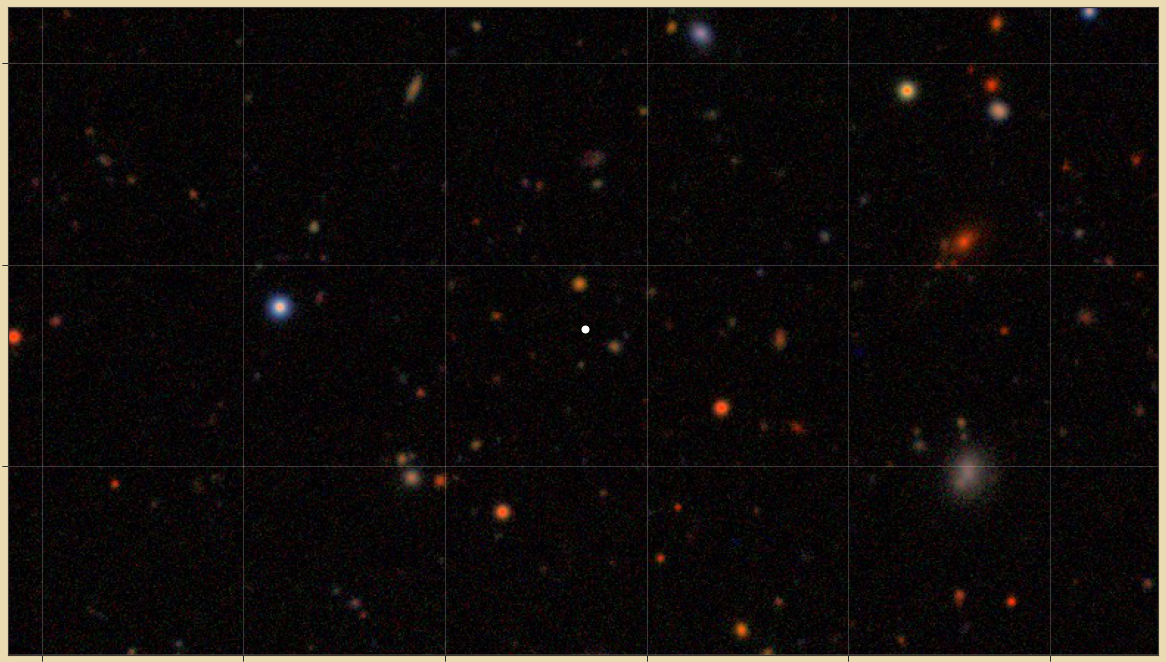

In [202]:
fig = pl.figure(figsize=(16,9))
def animate(i):  
    im = tiffzoom((220 + (i*5)))
anim = FuncAnimation(fig, animate,frames=356,interval=1,blit=False)
anim.save('a1s3.mp4', writer='ffmpeg', fps=60, dpi=80, bitrate=-1)   
Video("a1s3.mp4")

### Act 1 Scene 4
#### follow posterchild's path on smallmel
    in the final movie, I insert a timeline in-post (instead of using the Timeline class 
    in the cells below or those in Act 2); it is the best way to keep the timeline stationary while the axes change zooming+panning section

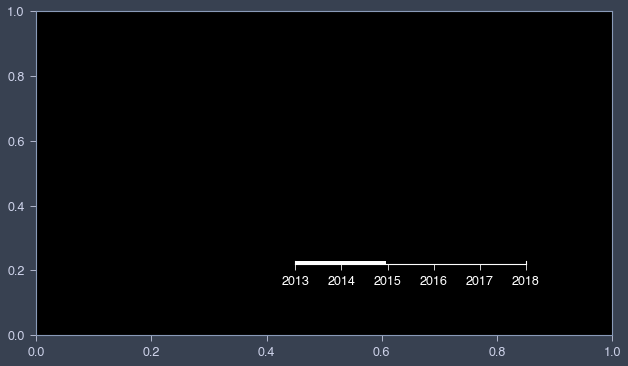

In [13]:
# Timeline Example
# I would insert a video like this in-post, masking the black background so that
# I can place the timeline directly on top of another video in Premiere
fig = pl.figure(figsize=(8,4.5))
pl.subplots_adjust(left=0, right=1, bottom=0, top=1)
#large default axes and random plotted point
ax0 = pl.gca()
ax0.patch.set_facecolor('black')
#defining and plotting the timeline
myline = Timeline(2013,2018)
ml = myline.plot(ax0, 0.45, 0.22)
#animating the timeline
def init():
    return ml
def animate(i):
    myline.time(i, 50)
    return ml
Writer = animation.writers['ffmpeg']
writer = Writer(fps=(60), metadata=dict(artist='Me'), bitrate=1800)
ani = animation.FuncAnimation(fig, animate, frames=(20), init_func=init, blit=False)
ani.save("timeline_example.mp4", writer=writer, dpi=80)
Video("timeline_example.mp4")

In [396]:
# utilize Orbit class for easy path calculation
poster_path_0 = Orbit(375).getPath(2013,1)
ras_0 = poster_path_0[0]
decs_0 = poster_path_0[1]

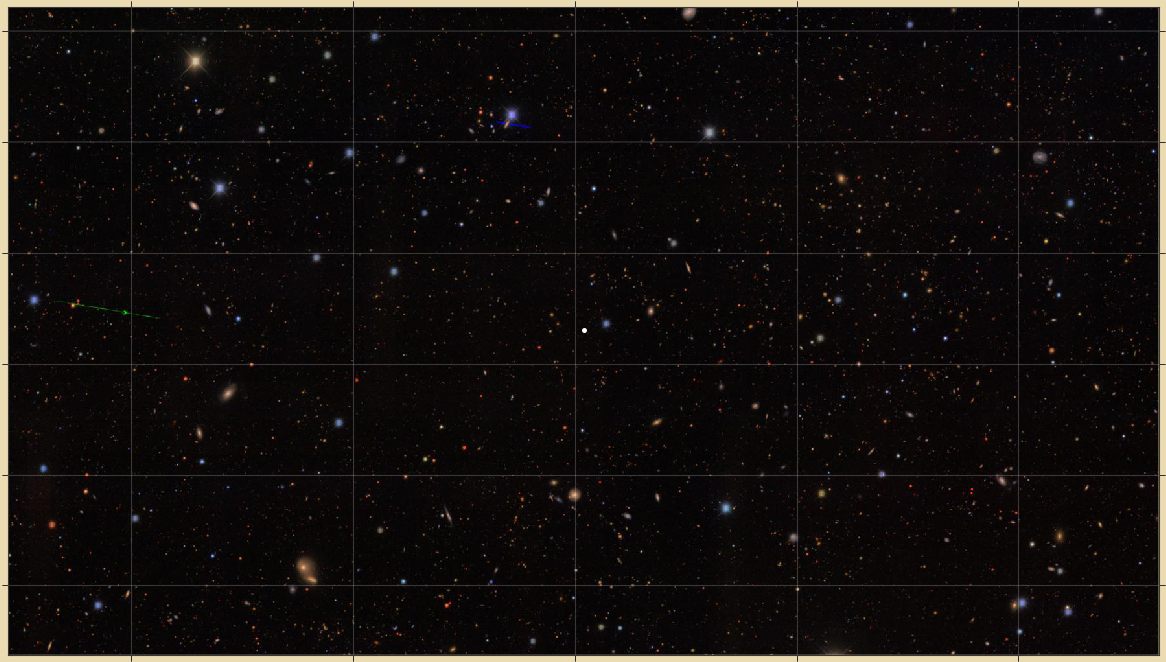

In [397]:
'''follow the path of the TNO on smallmel so that the "current" coordinate is 
always at the center of the frame.'''

w = smallmelwcs
fig = pl.figure(figsize=(16,9))

def animate(frame):
    # the center x and y value (units of ra dec)
    ra_c = ras_0[853+frame]
    dec_c = decs_0[853+frame]
    # calculate center x and y in pixel units, crop wcs and image accordingly
    difference = 500+frame
    xdiff = int(difference*1.777)
    center_x, center_y = w.all_world2pix(ra_c, dec_c, 0)
    crop_x= int(center_x) - xdiff
    crop_y= int(center_y) - difference    
    currentwcs = w[(crop_y):(int(center_y) + difference), (crop_x):(int(center_x) + xdiff)]
    ax1 = pl.subplot(projection=w[(crop_y):(int(center_y) + difference), (crop_x):(int(center_x) + xdiff)], slices=('x','y'))
    
    # image and formatting
    pl.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax1.imshow(smallmel[(crop_y):(int(center_y) + difference), (crop_x):(int(center_x) + xdiff)])
    lon1, lat1 = ax1.coords
    lon1.set_format_unit('deg', decimal=True)
    lon1.grid(color='white', alpha=0.2)
    lat1.set_format_unit('deg', decimal=True)
    lat1.grid(color='white', alpha=0.2)

    # path "tail" that grows with every frame
    tailx, taily = currentwcs.all_world2pix(ras_0[853:854+frame], decs_0[853:854+frame], 0)
    tailx = np.array(tailx)
    taily = np.array(taily)
    # make sure not to plot points which are out of the frame
    minx = ax1.get_xlim()[0]
    maxx = ax1.get_xlim()[1]
    miny = ax1.get_ylim()[0] 
    maxy = ax1.get_ylim()[1]
    tailx = np.where(tailx <= maxx, tailx, -1)
    tailx = np.where(tailx >= minx, tailx, -1)
    taily = np.where(taily >=miny, taily, -1)
    taily = np.where(taily <=maxy, taily, -1)
    new_tailx = np.delete(tailx, np.where(taily == -1))
    new_tailx = np.delete(new_tailx, np.where(new_tailx == -1))
    new_taily = np.delete(taily, np.where(tailx == -1))
    new_taily = np.delete(new_taily, np.where(new_taily == -1))
    # plot the tail
    ax1.plot(new_tailx, new_taily, color = '#DAB733', lw=3)
    
    # manually plot detection flashes, and make sure not to plot when detection is out of frame
    # (manual because Dot class wasn't working, possibly due to an update from y4 to y6 data)
    #  -> see Orbit(375).dots[3].coords vs. tnodetect[213][3]
    if frame < 49:
        ax1.autoscale(False)
        ax1.plot(tailx[0], taily[0], 'wo', alpha=1, markersize=5)
    if frame > 44:
        minmark = 5
        maxmark = 16
        ax1.plot(tailx[45], taily[45], 'wo', alpha=1, markersize = max((maxmark-((frame-44)*0.35)), minmark))
anim = FuncAnimation(fig, animate,frames=147,interval=1,blit=False)
anim.save('a1s4.mp4', writer='ffmpeg', fps=40, dpi=80, bitrate=-1) 
Video("a1s4.mp4")

after drawing posterchild's path through 2013:
- switch from smallmel to bigmel (smoothly)
- zoom out to desired frame (one which contains 5 moving TNOs)

In [352]:
# utilize Orbit class for easy path calculation
poster_path = Orbit(375).getPath(2013,1)
ras = poster_path[0]
decs = poster_path[1]

In [353]:
def outsmallmel(ra_c, dec_c, difference):
    '''function which zooms out as far as possible with the smallmel. at a certain point we hit the edge, then
    it's time to switch to mel2. 
    '''
    # set up figure and image; wcs and image bounds update every frame
    xdiff = int(difference*1.777)
    center_x, center_y = smallmelwcs.all_world2pix(ra_c, dec_c, 0)
    crop_x= int(center_x) - xdiff
    crop_y= int(center_y) - difference
    currentwcs = smallmelwcs[(crop_y):(int(center_y) + difference), (crop_x):(int(center_x) + xdiff)]
    ax1 = pl.subplot(projection=smallmelwcs[(crop_y):(int(center_y) + difference), (crop_x):(int(center_x) + xdiff)], slices=('x','y'))
    ax1.imshow(smallmel[(crop_y):(int(center_y) + difference), (crop_x):(int(center_x) + xdiff)])
    pl.subplots_adjust(left=0, right=1, bottom=0, top=1)
    lon1, lat1 = ax1.coords
    lon1.set_format_unit('deg', decimal=True)
    lon1.grid(color='white', alpha=0.2)
    lat1.set_format_unit('deg', decimal=True)
    lat1.grid(color='white', alpha=0.2)
    
    # calculate TNO path in current frame's wcs
    tailx, taily = currentwcs.all_world2pix(ras[853:999], decs[853:999], 0)
    tailx = np.array(tailx)
    taily = np.array(taily)
    
    minx = ax1.get_xlim()[0]
    maxx = ax1.get_xlim()[1]
    miny = ax1.get_ylim()[0] 
    maxy = ax1.get_ylim()[1]
    # make sure not to plot points which are out of the frame
    tailx = np.where(tailx <= maxx, tailx, -1)
    tailx = np.where(tailx >= minx, tailx, -1)
    taily = np.where(taily >=miny, taily, -1)
    taily = np.where(taily <=maxy, taily, -1)
    new_tailx = np.delete(tailx, np.where(taily == -1))
    new_tailx = np.delete(new_tailx, np.where(new_tailx == -1))
    new_taily = np.delete(taily, np.where(tailx == -1))
    new_taily = np.delete(new_taily, np.where(new_taily == -1))

    ax1.plot(new_tailx, new_taily, color = '#DAB733', lw=3)
    # manually plot the Dots, (Dot class wasn't working, possibly due to an update from y4 to y6 data)
    if difference>887:
        ax1.autoscale(False)
        ax1.plot(tailx[0], taily[0], 'wo', alpha=1, markersize=5)
    if difference > 657:
        ax1.autoscale(False)
        ax1.plot(tailx[45], taily[45], 'wo', alpha=1, markersize=5)

### Act 1 Scene 5
#### zoom out of smallmel

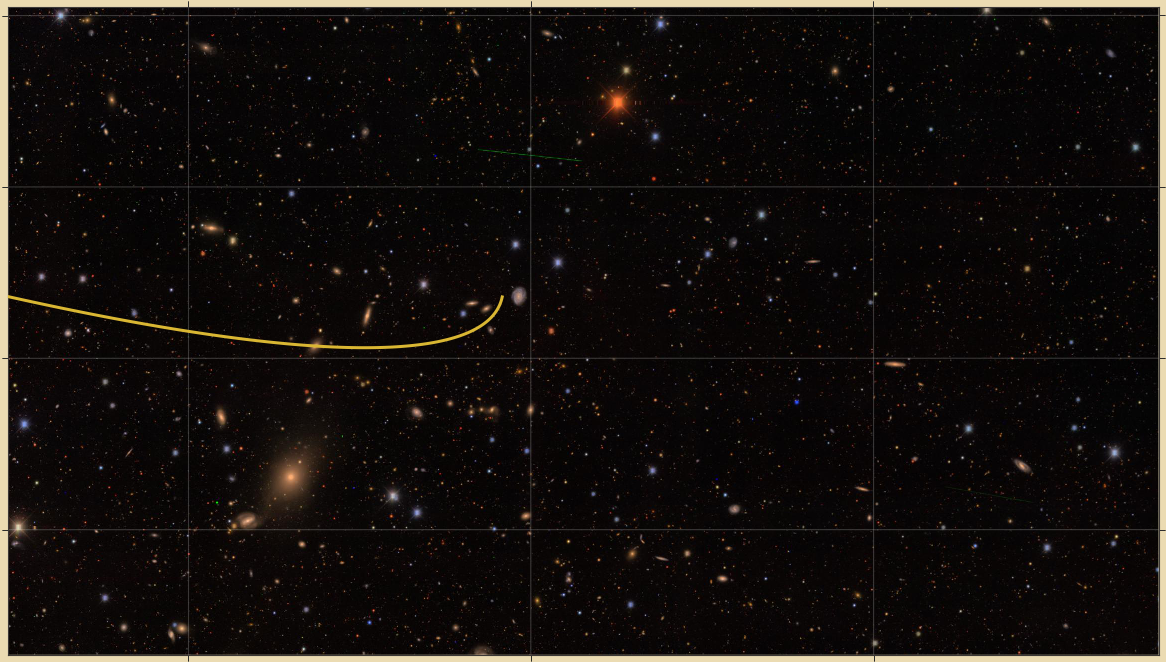

In [314]:
fig = pl.figure(figsize=(16,9))
def animate(i):
    outsmallmel(18.56908841087535+(i*0.005), 0.5162152145563456+(i*0.005), 647+(10*i))
anim = FuncAnimation(fig, animate,frames=60,interval=1,blit=False)
anim.save('a1s5.mp4', writer='ffmpeg', fps=20, dpi=80, bitrate=-1)   
Video("a1s5.mp4")

In [398]:
def outbigmel(ra_c, dec_c, difference):
    '''like above, just zooming out from bigmel'''
    # set up figure and image; wcs and image bounds update every frame
    xdiff = int(difference*1.777)
    center_x, center_y = bigmelwcs.all_world2pix(ra_c, dec_c, 0)
    crop_x= int(center_x) - xdiff
    crop_y= int(center_y) - difference
    currentwcs = bigmelwcs[int(crop_y):(int((center_y) + difference)), int(crop_x):int((int(center_x) + xdiff))]
    ax1 = pl.subplot(projection=bigmelwcs[int(crop_y):(int((center_y) + difference)), int(crop_x):int((int(center_x) + xdiff))], slices=('x','y'))
    pl.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax1.imshow(bigmel[int(crop_y):(int((center_y) + difference)), int(crop_x):int((int(center_x) + xdiff))])
    lon1, lat1 = ax1.coords
    lon1.set_format_unit('deg', decimal=True)
    lon1.grid(color='white', alpha=0.2)
    lat1.set_format_unit('deg', decimal=True)
    lat1.grid(color='white', alpha=0.2)
    
    # plot tno tail + detections
    tailx, taily = currentwcs.all_world2pix(ras[853:999], decs[853:999], 0) 
    ax1.plot(tailx, taily, color = '#DAB733', lw=3)
    ax1.plot(tailx[0], taily[0], 'wo', alpha=1, markersize=5)
    ax1.plot(tailx[45], taily[45], 'wo', alpha=1, markersize=5)

### Act 1 Scene 6
#### zoom out of bigmel

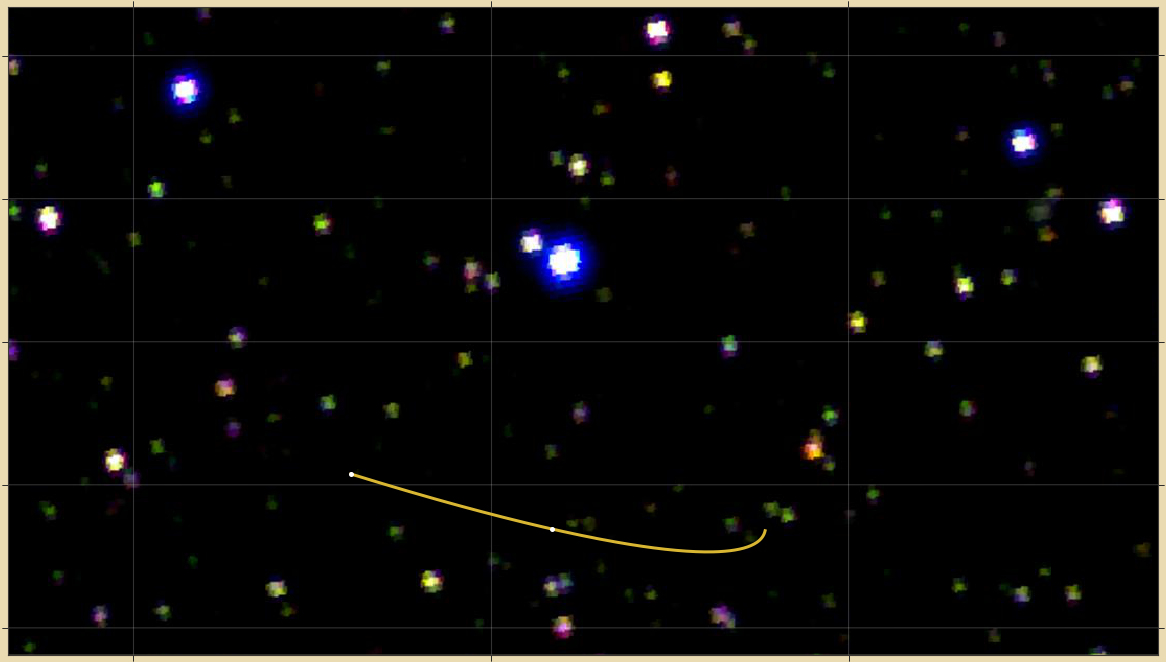

In [322]:
fig = pl.figure(figsize=(16,9))
def animate(i):
    outbigmel((18.86908841087535-(0.00029035364207593515*i)), (0.8162152145563455+(i*0.003189543561383547)), (310+(3.58*i)))
anim = FuncAnimation(fig, animate,frames=460,interval=1,blit=False) #460
anim.save('a1s6.mp4', writer='ffmpeg', fps=100, dpi=80, bitrate=-1)   
Video("a1s6.mp4")

***

# Act 2

Act 2 outline
- draw 5 TNO paths for 5 years
- ** change interval from 1000 to 300 (in orbitdot.py file, line 153, __ * tdbspan)

In [338]:
# the 5 stars of the show!
IDs5 = [375, 191, 439, 205, 248]
orbs5 = [Orbit(IDs5[k]) for k in range(len(IDs5))]
color_array = ['#DAB733', '#2B6FB0', '#B0302B', '#8FB339','#7E6AB4'] # their respective colors

In [359]:
# the appropriate crop of bigmel and its wcs
difference = 2100
xdiff = int(difference*1.777)
center_x = 4100
center_y = 4900
crop_x= int(center_x) - xdiff
crop_y= int(center_y) - difference    
bigmelwcs_crop = bigmelwcs[crop_y:(int(center_y) + difference),crop_x:(int(center_x) + xdiff)]

In [400]:
# load necessary information: each TNO's cue frame (detindeces), clock for detection flash timing
infos5 = [orbs5[j].getPath(2013,5) for j in range(len(IDs5))]
detindeces = [infos5[j][7] for j in range(len(IDs5))]
clock = infos5[0][2]

In [345]:
# path coordinates in the first wcs (a crop of bigmelwcs); first 2 years
firstpath_wcs1 = [orbs5[j].wcsPath(bigmelwcs_crop,2013,2)[1] for j in range(len(orbs5))]

In [346]:
# path coordinates in the second wcs (biggermelwcs); next 3 years
firstpath_wcs2 = [orbs5[j].wcsPath(biggermelwcs,2013,2)[1] for j in range(len(orbs5))]
nextpath_wcs2 = [orbs5[j].wcsPath(biggermelwcs,2015,3)[1] for j in range(len(orbs5))]

### Act 2 Scene 1
#### 2013-2015: drawing 5 paths without panning or zooming

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

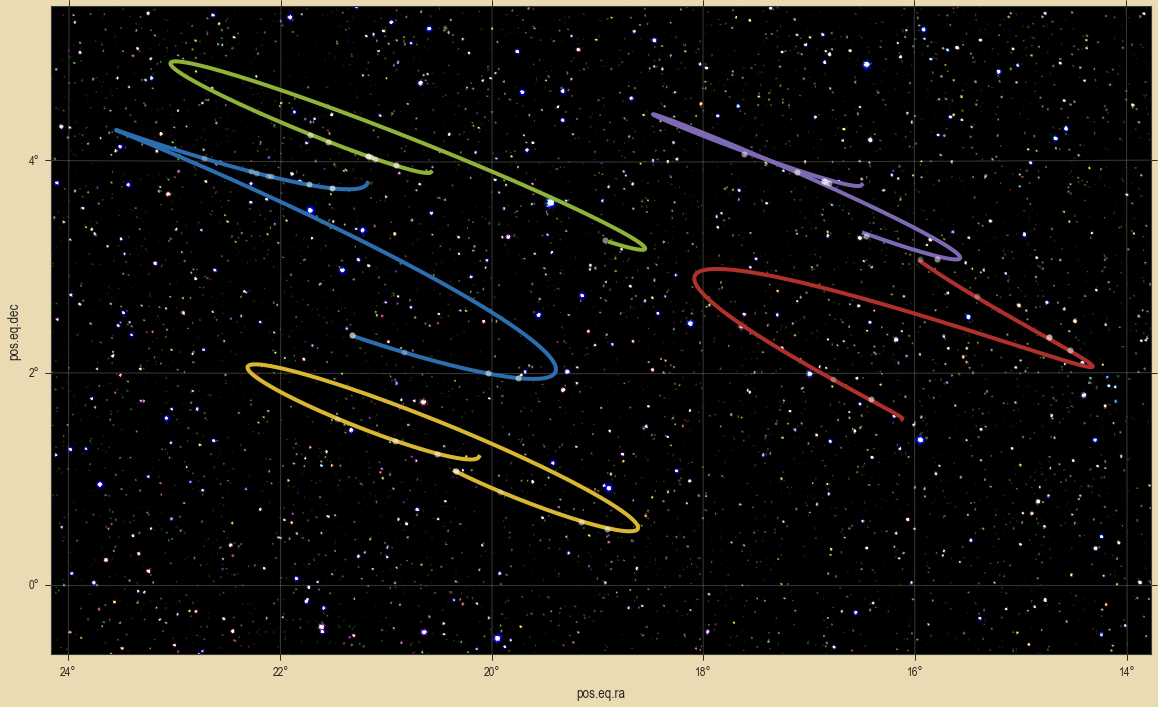

In [360]:
fig = pl.figure(figsize=(16,9))

ax1 = pl.subplot(projection=bigmelwcs_crop, slices=('x','y'))
pl.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax1.imshow(bigmel[crop_y:(int(center_y) + difference),crop_x:(int(center_x) + xdiff)])
lon1, lat1 = ax1.coords
lon1.set_format_unit('deg', decimal=True)
lon1.grid(color='white', alpha=0.2)
lat1.set_format_unit('deg', decimal=True)
lat1.grid(color='white', alpha=0.2)
ax1.autoscale(False)

# automate needed pl.plots
points = [pl.plot([], [], '-', color=color_array[i], lw=4)[0] for i in range(len(IDs5))]
xdata = [[] for i in range(len(orbs5))]
ydata = [[] for i in range(len(orbs5))]

# define animation writer
Writer = animation.writers['ffmpeg']
writer = Writer(fps=(60), metadata=dict(artist='Me'), bitrate=-1)

#animate
def init():  
    return points
def update(frame):
    for i in range(len(IDs5)): 
        if frame > detindeces[i]:
            # append path data to each respective pl.plot with every frame
            x = firstpath_wcs1[i][0][frame-detindeces[i]]
            y = firstpath_wcs1[i][1][frame-detindeces[i]]
            xdata[i].append(x)
            ydata[i].append(y)
            points[i].set_data(xdata[i], ydata[i])
        # detection flashes
        orbs5[i].wcsDrawDots(bigmelwcs_crop, ax1, clock[frame].value, col="white")
        # in actual movie, the Dot class has larger flashes, see orbitdot file.
        # they are small now because I shrank the flashes for the end of the movie
    print(frame)
    return points

# save work
ani = FuncAnimation(fig, update, frames=600,init_func=init, blit=True)
ani.save("a2s1.mp4", writer=writer)
Video("a2s1.mp4")

### Act 2 Scene 2
##### 2015 - 2016: drawing and panning left+up

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

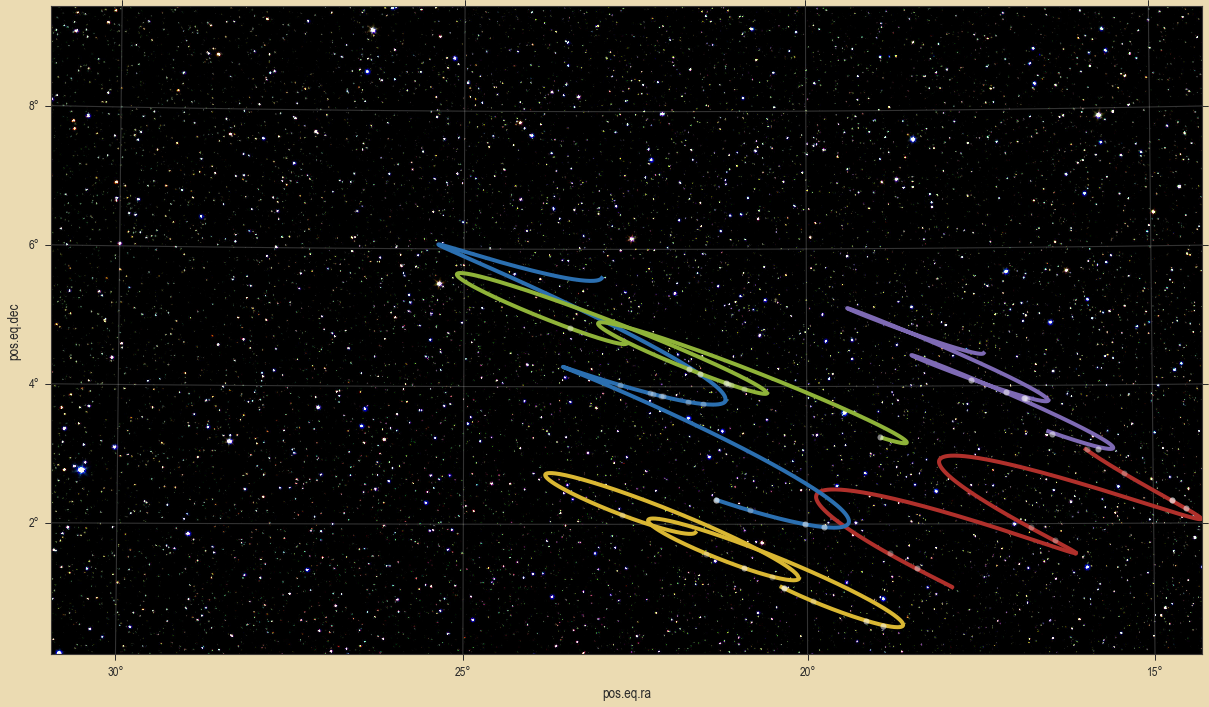

In [357]:
fig = pl.figure(figsize=(16,9))

ax1 = pl.subplot(projection=biggermelwcs, slices=('x','y'))
pl.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax1.imshow(biggermel[::-1])
lon1, lat1 = ax1.coords
lon1.set_format_unit('deg', decimal=True)
lon1.grid(color='white', alpha=0.2)
lat1.set_format_unit('deg', decimal=True)
lat1.grid(color='white', alpha=0.2)
ax1.autoscale(False)

# automate needed pl.plots
points = [pl.plot([], [], '-', color=color_array[i], lw=4)[0] for i in range(len(orbs5))]
xdata = [[] for i in range(len(orbs5))]
ydata = [[] for i in range(len(orbs5))]

# plot 2013-2015 path
for o in range(len(orbs5)):
    ax1.plot(firstpath_wcs2[o][0], firstpath_wcs2[o][1], color=color_array[o], lw=4)

# animate 2015-2017 path and move screen (adjust axis limits)
def init():  
    return points
def update(frame):
    for i in range(len(orbs5)): 
        # append path data to each respective pl.plot with every frame
        x = nextpath_wcs2[i][0][frame]
        y = nextpath_wcs2[i][1][frame]
        xdata[i].append(x)
        ydata[i].append(y)
        points[i].set_data(xdata[i], ydata[i])
        orbs5[i].wcsDrawDots(biggermelwcs, ax1, clock[frame+599].value, col="white")
        
        # adjust axes limits for pan and zoom effect
        difference = 1000 + ((1700 - 1000)/300)*frame
        center_x = 4300 + ((3010 - 4300)/300)*frame
        center_y =  2400 + ((3179 - 2400)/300)*frame
        xdiff = int(difference*1.777)
        crop_x= int(center_x) - xdiff
        crop_y= int(center_y) - difference
        ax1.set_xlim(crop_x, (int(center_x) + xdiff))
        ax1.set_ylim(crop_y, (int(center_y) + difference))
    print(frame)
    return points

# define animation writer
Writer = animation.writers['ffmpeg']
writer = Writer(fps=(60), metadata=dict(artist='Me'), bitrate=-1)
# save work
ani = FuncAnimation(fig, update, frames=300,init_func=init, blit=True)
ani.save("a2s2.mp4", writer=writer)
Video("a2s2.mp4")

### Act 2 Scene 3
#### 2016-2019: last scene before zooming out to full survey

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


0


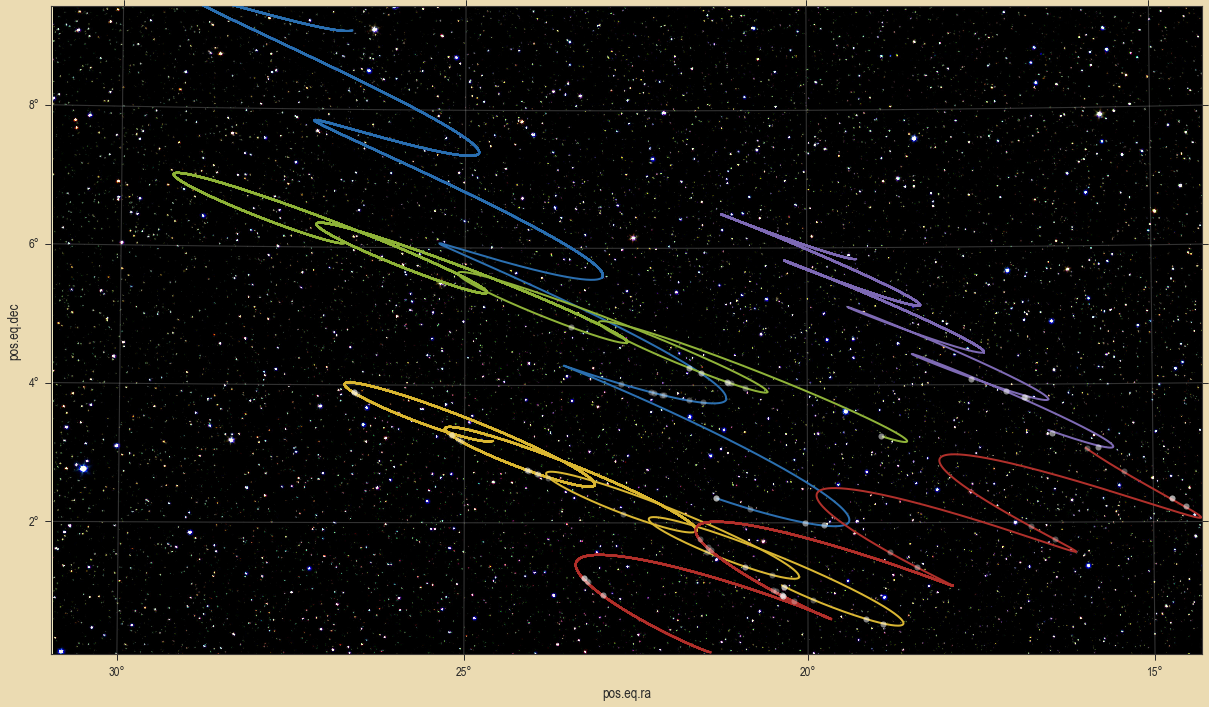

In [356]:
fig = pl.figure(figsize=(16,9))
ax = pl.subplot(projection=biggermelwcs, slices=('x','y'))
pl.subplots_adjust(left=0, right=1, bottom=0, top=1)

ax.imshow(biggermel[::-1])
lon, lat = ax.coords
lon.set_format_unit('deg', decimal=True)
lon.grid(color='white', alpha=0.2)
lat.set_format_unit('deg', decimal=True)
lat.grid(color='white', alpha=0.2)
# the landing crop from previous scene
difference = 1700
xdiff = int(difference*1.777)
center_x = 3010
center_y = 3170
crop_x= int(center_x) - xdiff
crop_y= int(center_y) - difference

# plot 2013-2016 path
for i in range(len(IDs5)):
    ax.autoscale(False)
    ax.plot(firstpath_wcs2[i][0], firstpath_wcs2[i][1], lw=2, color = color_array[i])
    ax.plot(nextpath_wcs2[i][0][:299], nextpath_wcs2[i][1][:299], lw=2, color = color_array[i])

ax.set_xlim(crop_x,(int(center_x) + xdiff))
ax.set_ylim(crop_y, (int(center_y) + difference))        

def animate(i):
    for o in range(len(IDs5)):
        # for some reason I switched up my animation method; it's a little faster, but
        # a little messier. Instead of appending data to a single pl.plot for each TNO,
        # we are plotting entire lines on top of each other which get longer and longer
        # in each frame. This only works here because we are no longer moving the camera.
        x_s = nextpath_wcs2[o][0][299:i+300]
        y_s = nextpath_wcs2[o][1][299:i+300]
        ax.plot(x_s, y_s, color=colorarray[o], lw=2)
        orbs5[o].wcsDrawDots(biggermelwcs, ax, clock[i+899].value, col="white")
    print(i)
        
anim = FuncAnimation(fig, animate,frames=600,interval=1,blit=False)
anim.save('a2s3.mp4', writer='ffmpeg', fps=60, dpi=80, bitrate=-1)  
Video('a2s3.mp4')